In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import sys
import json
import time
from shapely.geometry import box,LineString,Point,MultiPoint,MultiLineString,MultiPolygon,Polygon
from shapely.ops import unary_union
import socket
from collections import defaultdict
from numba import prange
import gc
current_dir = os.path.join(os.getcwd()) 
mother_path = os.path.abspath(os.path.join(current_dir, os.pardir))
print('mother_path:', mother_path)
sys.path.append(os.path.join(mother_path, 'PreProcessing'))
sys.path.append(os.path.join(mother_path))
from FittingProcedures import *
from plot import *
from Potential import *
from Grid import *
from PreprocessingObj import *
from ODfromfma import *
import time
from GeometrySphere import *
from Polycentrism import *
from PolycentrismPlot import *
from ModifyPotential import *
from MainPolycentrism import *

#import rustworkx as rw
import ast
## BASIC PARAMS
gc.set_threshold(10000,50,50)
plt.rcParams.update({
    "text.usetex": False,
})

if socket.gethostname()=='artemis.ist.berkeley.edu':
    TRAFFIC_DIR = '/home/alberto/LPSim/traffic_phase_transition'
else:
    TRAFFIC_DIR = os.getenv('TRAFFIC_DIR')
name = 'BOS'
grid_size = 0.02
hexagon_resolution = 8
dir_grid = os.path.join(TRAFFIC_DIR,'data','carto',name,'grid',str(grid_size))

## BASIC NEEDED OBJECTS
SFO_obj = GeometricalSettingsSpatialPartition(name,TRAFFIC_DIR)
bbox = SFO_obj.bounding_box
minx, miny, maxx, maxy = bbox
dir_geometries = os.path.join(TRAFFIC_DIR,'data','carto','{0}'.format(name))
grid = GetGrid(grid_size,SFO_obj.bounding_box,'EPSG:4326',dir_geometries)
grid = GetBoundariesInterior(grid,SFO_obj)
df_distance,FoundDistMat = GetDirectionMatrix(dir_geometries,grid_size)
Tij = GetODGrid(dir_geometries,str(grid_size))
lattice = nx.read_graphml(os.path.join(dir_grid,"centroid_lattice.graphml"))
#VectorField = pd.read_csv('/home/alberto/LPSim/traffic_phase_transition/data/carto/BOS/grid/0.02/VectorField.csv')
#Potential = pd.read_csv('/home/alberto/LPSim/traffic_phase_transition/data/carto/BOS/grid/0.02/PotentialDataFrame.csv')

# GET POTENTIAL AND VECTOR FIELD
VectorField = GetVectorField(Tij,df_distance)
VectorFieldDir = os.path.join(TRAFFIC_DIR,'data','carto',name,'grid',str(grid_size))
lattice = GetPotentialLattice(lattice,VectorField)
lattice = SmoothPotential(lattice)
PotentialDataframe = ConvertLattice2PotentialDataframe(lattice)
PotentialDataframe = CompletePotentialDataFrame(VectorField,grid,PotentialDataframe)
SumPot = np.sum(PotentialDataframe['V_out']) 
NumGridEdge = grid[grid['relation_to_line']=='edge'].shape[0]




mother_path: /home/aamad/Desktop/phd/berkeley/traffic_phase_transition/scripts


/home/aamad/anaconda3/envs/geostuff/lib/python3.12/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


Initialize Grid: 0.02
ALREADY COMPUTED


# Compute Boundaries

# COMPUTE PI

##### FIND VMAX

In [ ]:
'''
Look for maximal configuration of POT D POT. I do not trust the Pereira approach to the problem.
Input:
    Indices of the grid that are inside the polygon
Description:
    Looking for max starting from an homogeneous configuration of the potential fixed the distances among different parts of the grid
'''
import numpy as np
from scipy.optimize import minimize,anneal
from deap import base, creator, tools, algorithms
from pyswarm import pso

# Objective function
def objective_function(ViVj,Filtered_Distance):
    return np.sum(ViVj * Filtered_Distance)

# Constraint function: sum of rows and columns should be constant
def constraint_function(V,SumPot):
    return np.sum(V, axis=0) - constant_sum_rows

def MinimizationSquares(initial_V,d_ij,SumPot,verbose = True):
    '''
        Trying to minimize the V function for the PI. 
        I do not trust the ansatz Pereira uses to define the most polycentric city.
    '''
    # Bounds for V (optional, but can help guide the optimization)
    bounds = [(0, SumPot)] * len(initial_V)  # V_i should be non-negative
    # Constraints for V (equality constraints for sum of rows and columns)
    constraints = ({'type': 'eq', 'fun': constraint_function})
    # Optimization
    result = minimize(objective_function, initial_V.flatten(), args=(d_ij.flatten()), method='SLSQP', bounds=bounds, constraints=constraints)
    # Reshape the optimized V matrix
    optimal_V = result.x.reshape(3, 3)
    if verbose:
        print("Optimal V:")
        print(optimal_V)
        print("Objective function value:", result.fun)

def MinimizationAnnealing(initial_V,d_ij,verbose = True):
    result = anneal(objective_function, initial_V.flatten(), args=(d_ij.flatten()), constraint=constraint_function)

    # Reshape the optimized V matrix
    optimal_V = result.reshape(3, 3)
    if verbose:
        print("Optimal V:")
        print(optimal_V)
        print("Objective function value:", objective_function(optimal_V.flatten(), d_ij.flatten()))    


def MinimizationByGeneticAlgo(verbose = True):
    creator.create("FitnessMax", base.Fitness, weights=(-1.0,))
    creator.create("Individual", np.ndarray, fitness=creator.FitnessMax)

    toolbox = base.Toolbox()
    toolbox.register("attr_float", np.random.uniform, 0, 10)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=9)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    toolbox.register("evaluate", objective_function, d=d_ij.flatten())
    toolbox.register("mate", tools.cxBlend, alpha=0.5)
    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.1)
    toolbox.register("select", tools.selTournament, tournsize=3)

    # Optimization
    population = toolbox.population(n=50)
    algorithms.eaMuPlusLambda(population, toolbox, mu=50, lambda_=100, cxpb=0.5, mutpb=0.2, ngen=100)

    # Get the best individual
    best_individual = tools.selBest(population, k=1)[0]

    # Reshape the optimized V matrix
    optimal_V = np.array(best_individual).reshape(3, 3)
    if verbose:
        print("Optimal V:")
        print(optimal_V)
        print("Objective function value:", objective_function(best_individual, d_ij.flatten())[0])    


##### COMPUTE POLYCENTRISM

# GENERATE NEW CONFIGURATIONS

Filtered Potential:  621
Filtered Distance:  385641
N**2:  385641
Vmax:  9.137459701352447e-05 V:  2.3520721534742942e-05
PI:  0.7425901475520422
*********** LORENZ CURVE ************
cumulative:  [-0.00395261 -0.00789154 -0.01181514 ...  0.97283887  0.98629814
  1.        ]
Fstar:  3405
index:  11839185
*************************************
*********** COMPUTE UCI ************
Sum Potential:  249822473.91772282
Number of Edges boundary:  621
LC:  0.9792924935289042 PI:  0.7425901475520422 UCI:  0.7272129572662364
*********** END UCI ************
InfoconfigurationPolicentricity:  137098313737152
InfoconfigurationPolicentricity[num_peaks]:  137092415179648
InfoConfigurationPolicentricity[num_peaks]['grid']:  137095817224912
InfoConfigurationPolicentricity[num_peaks]['Tij']:  137095822116384
grid:  137096248600544
Tij:  137095789867952
Modified_Fluxes:  137095864425168
New_Vector_Field:  137095808231872
New_Potential_Dataframe:  137095802891744
df_distance:  137095761696992
SFO_obj:  137

/home/aamad/Desktop/phd/berkeley/traffic_phase_transition/scripts/GeometrySphere/Polycentrism.py:222: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  PotentialDataframe['V_out'][MaskOutside] = 0
/home/aamad/Desktop/phd/berkeley/traffic_phase_t

+++++ Plot Fluxes +++++
Type origin:  <class 'numpy.ndarray'>
Type destination:  <class 'numpy.ndarray'>
Type fluxes:  <class 'numpy.ndarray'>
Grid index:  0
i:  1791  j:  1791
x of i:  -71.098385
y of i:  42.252821
x of j:  -71.098385
y of j:  42.252821
Grid index:  1
i:  1795  j:  1795
x of i:  -71.098385
y of i:  42.332821
x of j:  -71.098385
y of j:  42.332821
Grid index:  2
i:  1757  j:  1757
x of i:  -71.118385
y of i:  42.712821
x of j:  -71.118385
y of j:  42.712821
Grid index:  3
i:  1829  j:  1829
x of i:  -71.078385
y of i:  41.872821
x of j:  -71.078385
y of j:  41.872821
Grid index:  4
i:  3311  j:  3311
x of i:  -70.558385
y of i:  41.872821
x of j:  -70.558385
y of j:  41.872821
Grid index:  5
i:  1792  j:  1792
x of i:  -71.098385
y of i:  42.272821
x of j:  -71.098385
y of j:  42.272821
Grid index:  6
i:  1794  j:  1794
x of i:  -71.098385
y of i:  42.312821
x of j:  -71.098385
y of j:  42.312821
Grid index:  7
i:  1790  j:  1790
x of i:  -71.098385
y of i:  42.232821


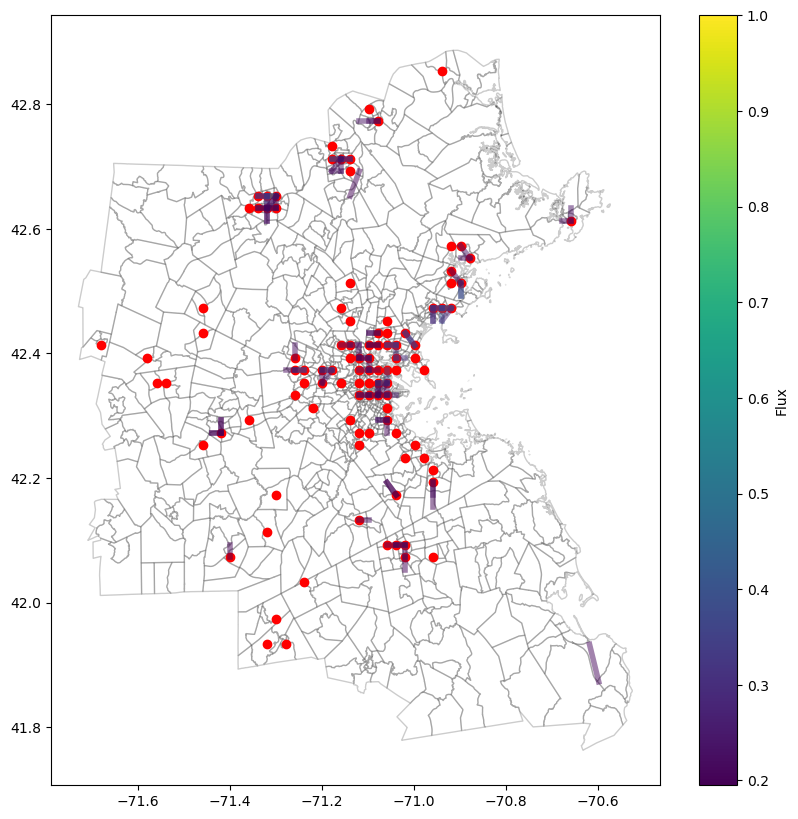

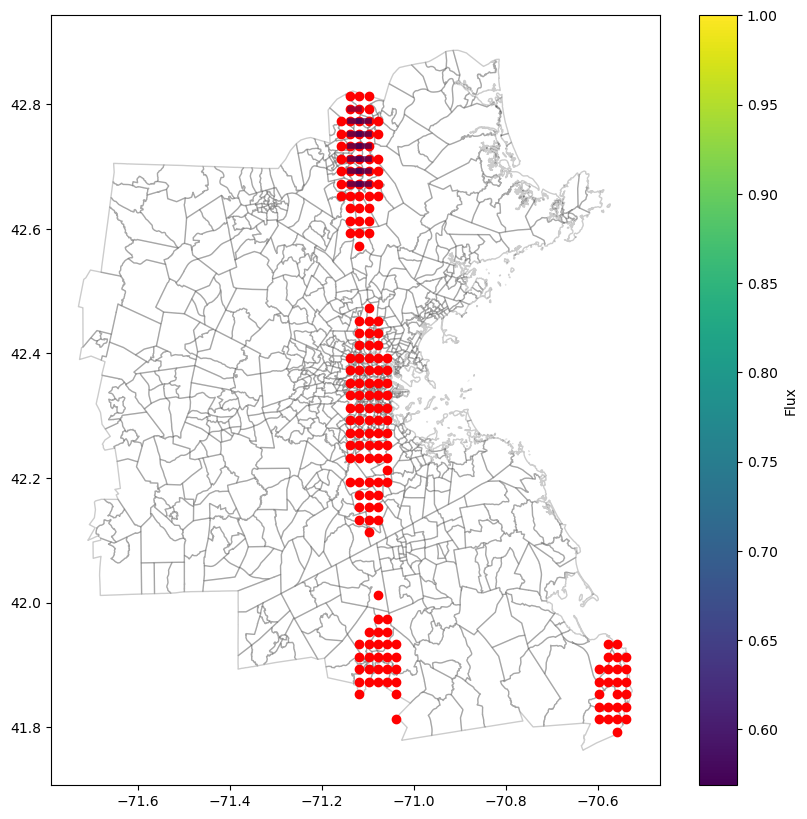

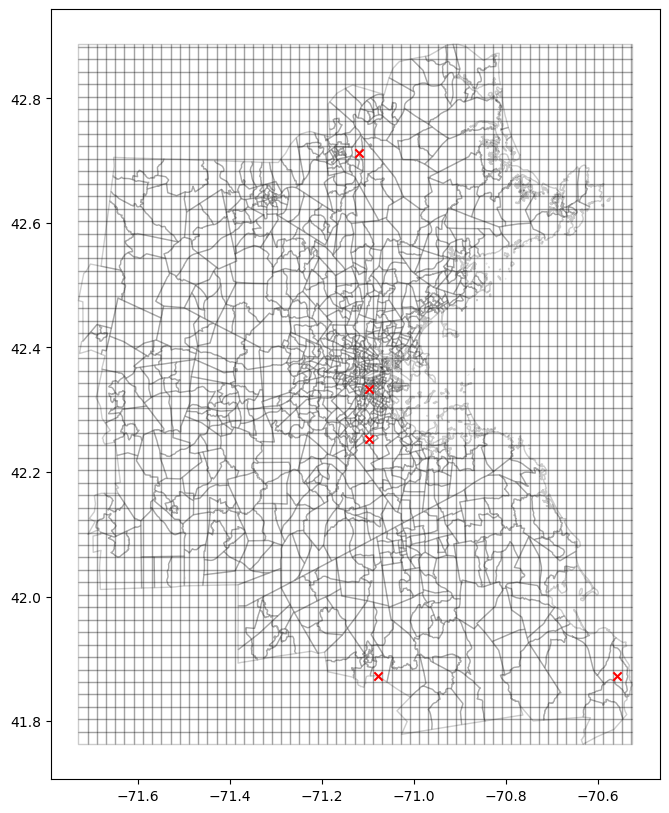

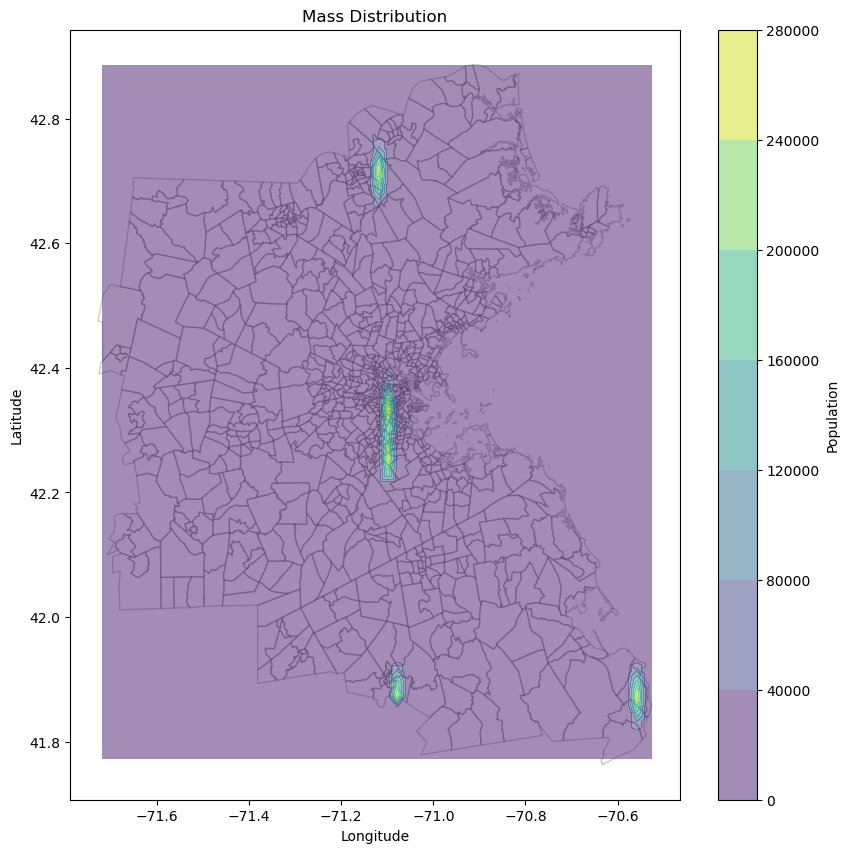

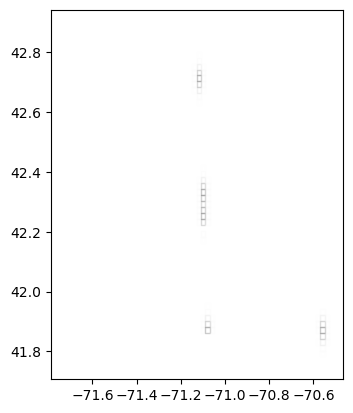

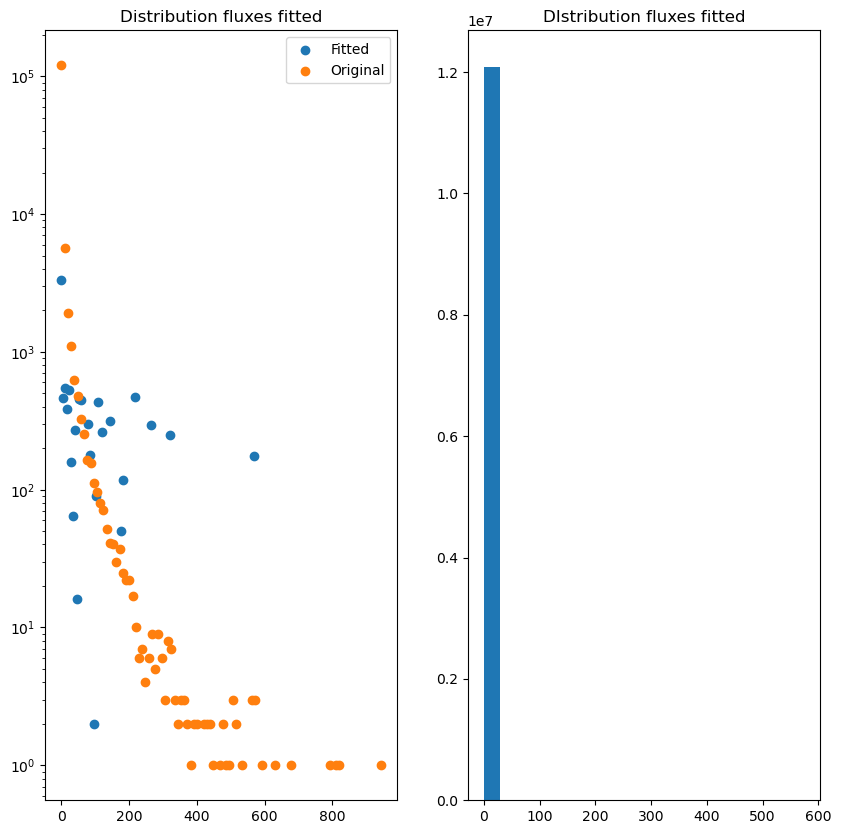

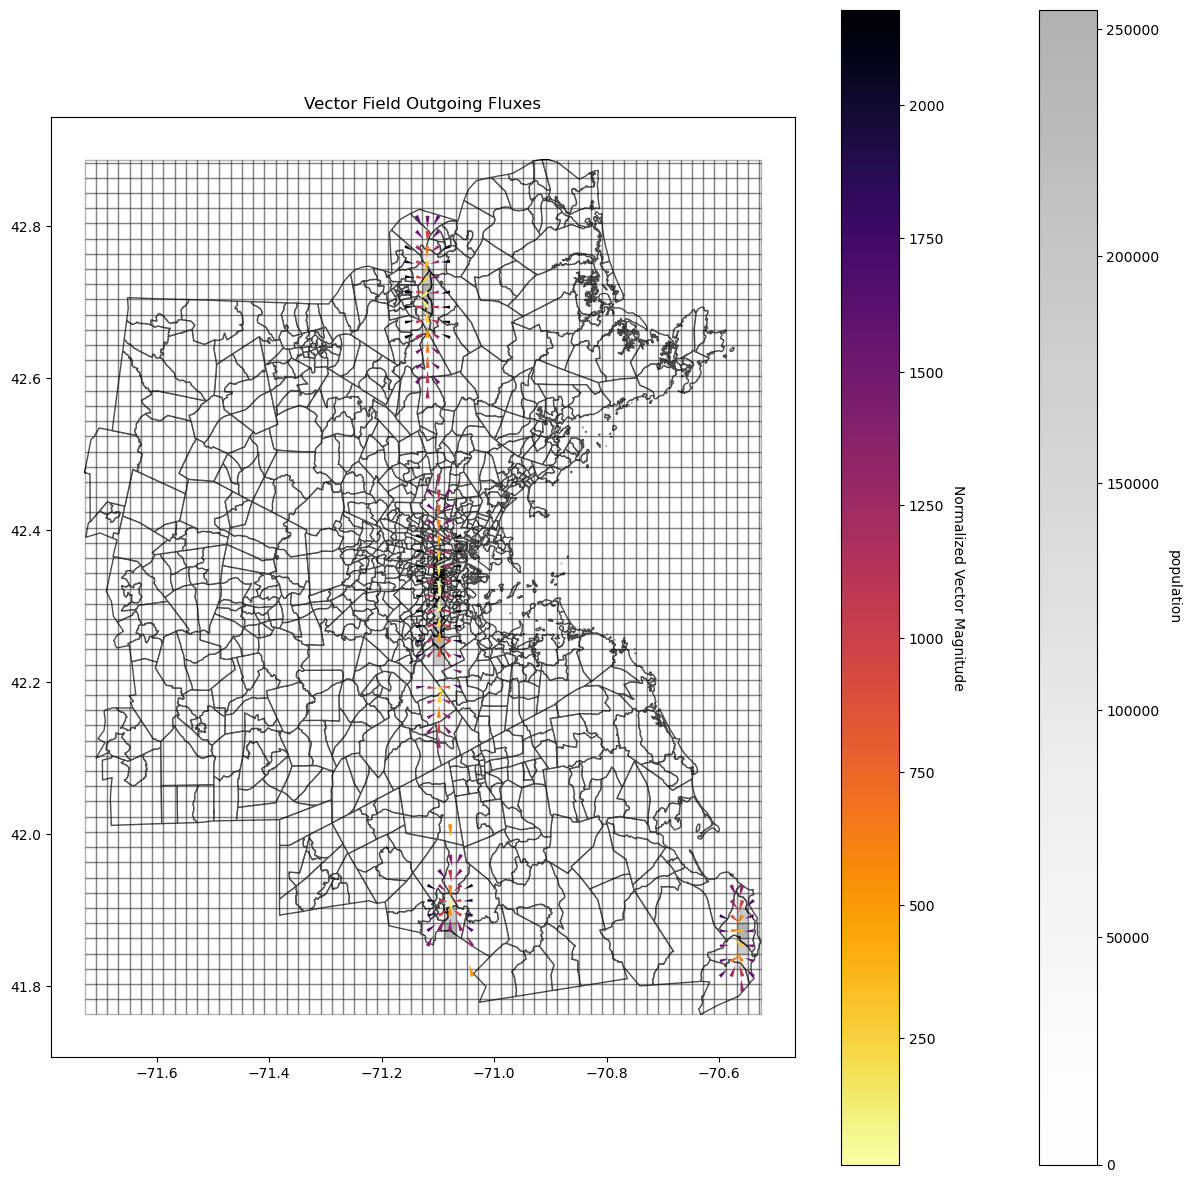

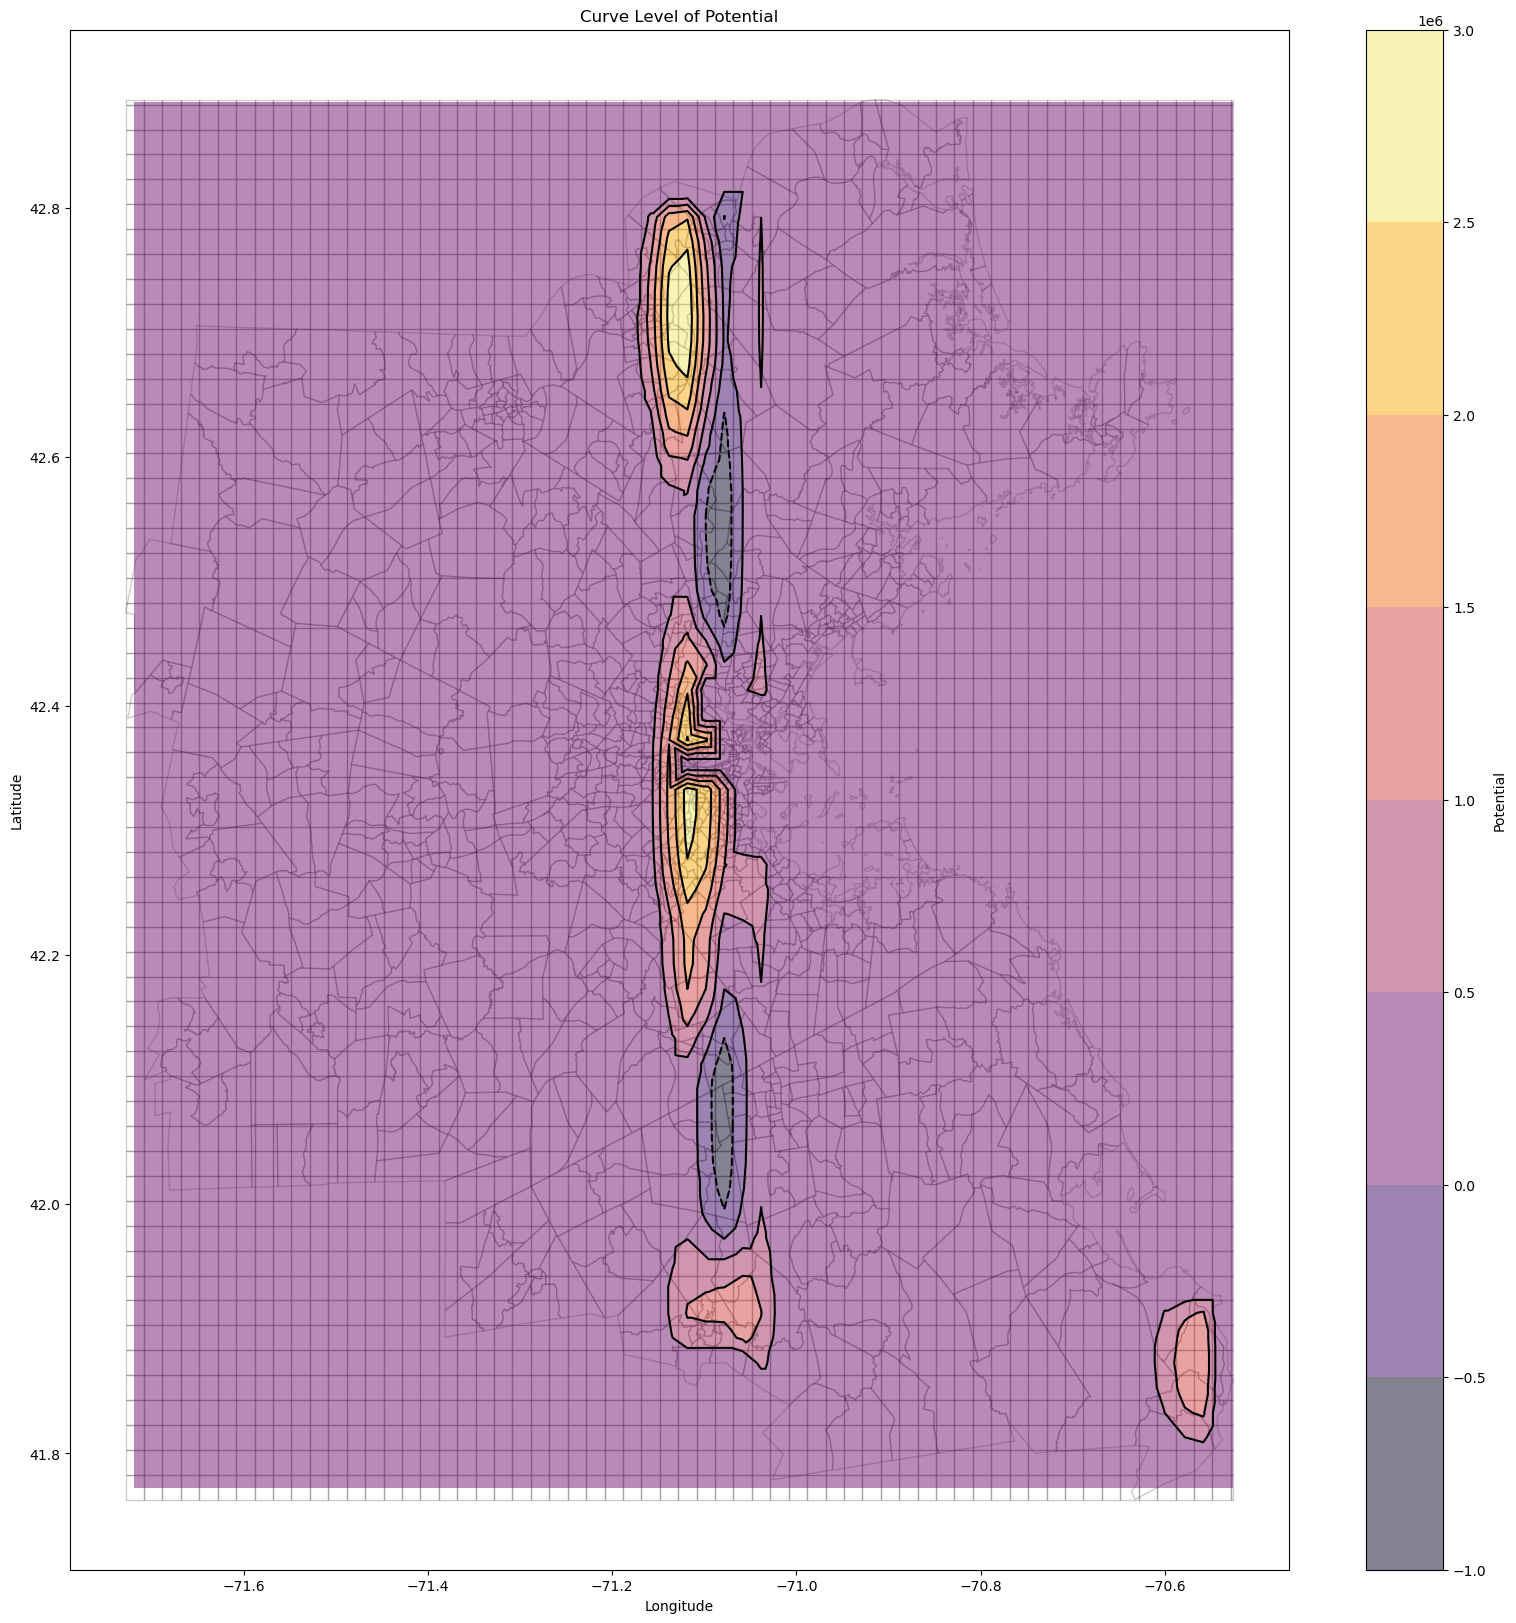

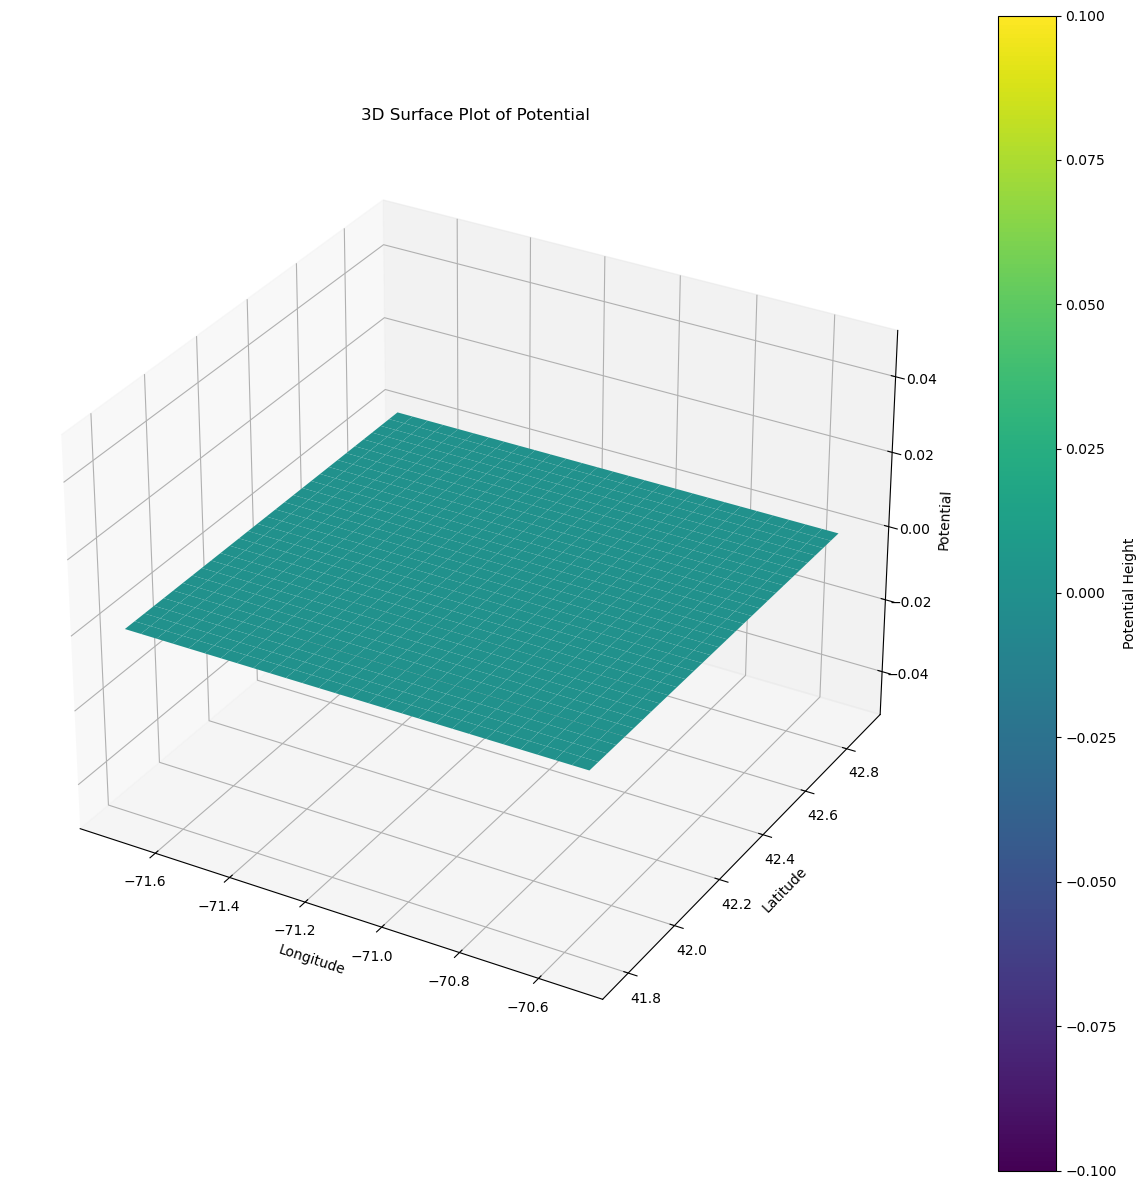

3405


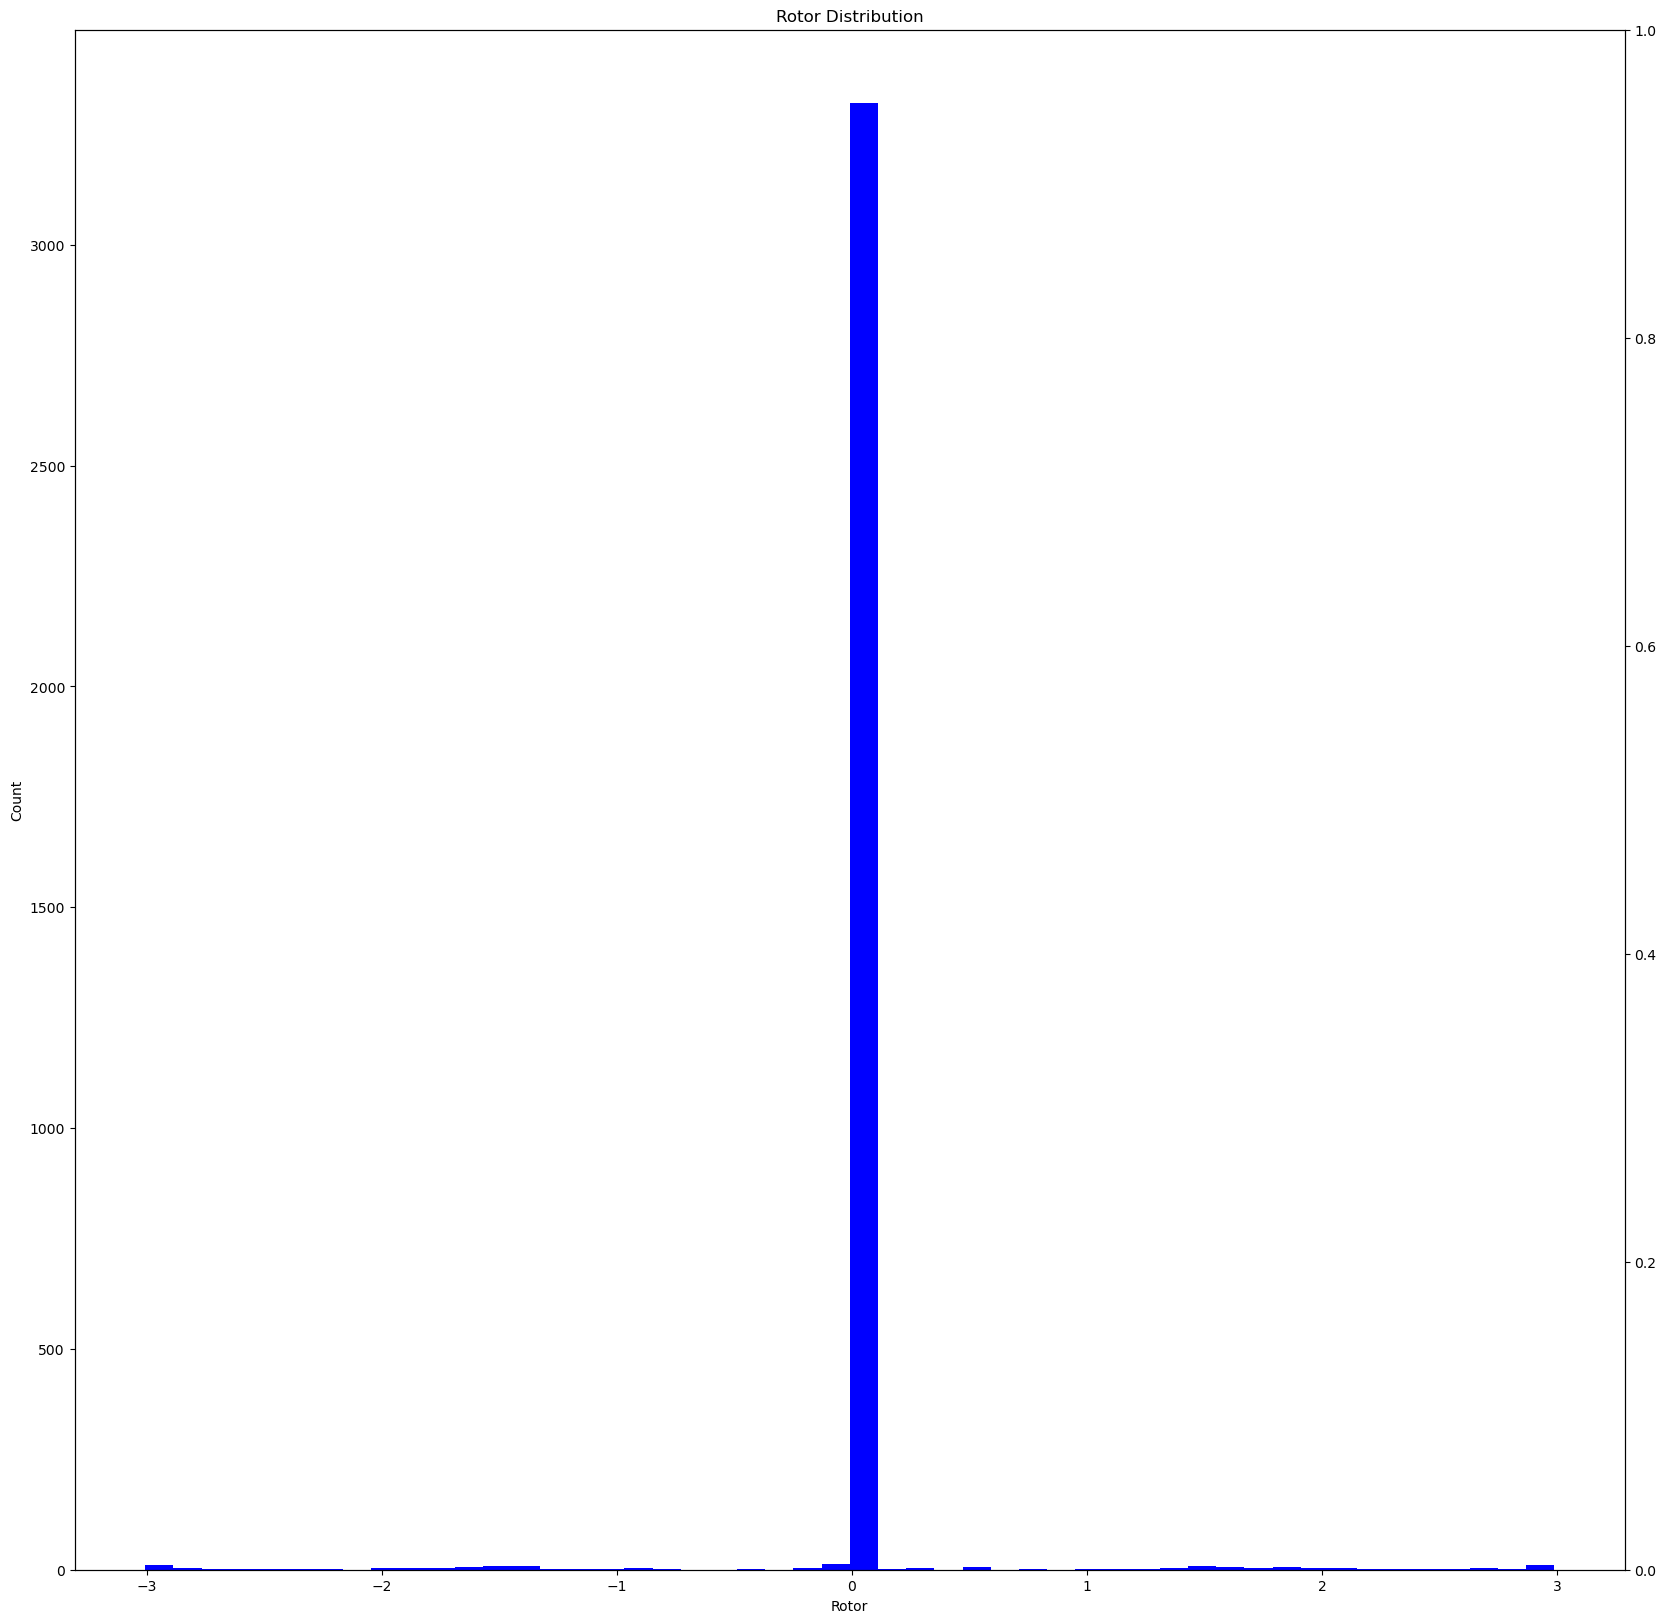

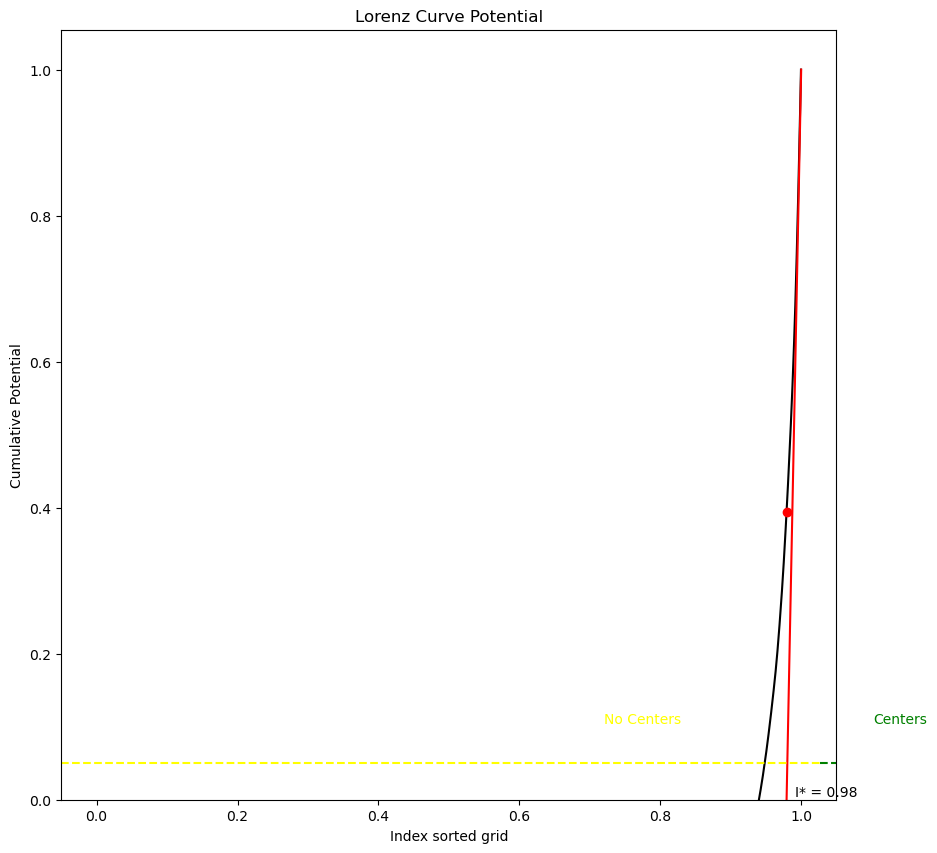

index Fstar:  3405
cumulative:  [-0.00395261 -0.00789154 -0.01181514 ...  0.97283887  0.98629814
  1.        ]
x:  [0.00000000e+00 2.87604257e-04 5.75208513e-04 ... 9.99137187e-01
 9.99424791e-01 9.99712396e-01]
x[idxFstar]:  0.9792924935289042
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
Modify Morphology 6
******************
Number of grids with people:  2157
Number of couples of grids with flux:  131478
Total Population:  4546481.94410453
Total Flux:  681885
Fraction of grids populated:  0.6203623813632442
Fraction of couples of grids with fluxes:  0.010875361645602571
******************
Plotting fluxes coming from raw data
PIPELINE MODIFICATION FLUXES starting...
++++++++++++ Generate Index Centers ++++++++++++
Number of Populated Grids:  1857
Average distance from Center:  28.965270752306463
Distance from Center Extracted: 
24.461511328700556
50.82268235540066
2.9974717867907255
2.959085680369588
46.14275674998635
10.010990013046333
Grid selected:  [1174, 547, 1734, 1681, 2856, 1954]
+

/home/aamad/Desktop/phd/berkeley/traffic_phase_transition/scripts/GeometrySphere/Polycentrism.py:222: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  PotentialDataframe['V_out'][MaskOutside] = 0
/home/aamad/Desktop/phd/berkeley/traffic_phase_t

+++++ Plot Fluxes +++++
Type origin:  <class 'numpy.ndarray'>
Type destination:  <class 'numpy.ndarray'>
Type fluxes:  <class 'numpy.ndarray'>
Grid index:  0
i:  1681  j:  1681
x of i:  -71.138385
y of i:  42.332821
x of j:  -71.138385
y of j:  42.332821
Grid index:  1
i:  1734  j:  1734
x of i:  -71.118385
y of i:  42.252821
x of j:  -71.118385
y of j:  42.252821
Grid index:  2
i:  547  j:  547
x of i:  -71.538385
y of i:  42.452821
x of j:  -71.538385
y of j:  42.452821
Grid index:  3
i:  1174  j:  1174
x of i:  -71.318385
y of i:  42.452821
x of j:  -71.318385
y of j:  42.452821
Grid index:  4
i:  1954  j:  1954
x of i:  -71.038385
y of i:  42.092821
x of j:  -71.038385
y of j:  42.092821
Grid index:  5
i:  2856  j:  2856
x of i:  -70.718385
y of i:  41.892821
x of j:  -70.718385
y of j:  41.892821
Grid index:  6
i:  546  j:  546
x of i:  -71.538385
y of i:  42.432821
x of j:  -71.538385
y of j:  42.432821
Grid index:  7
i:  548  j:  548
x of i:  -71.538385
y of i:  42.472821
x of j

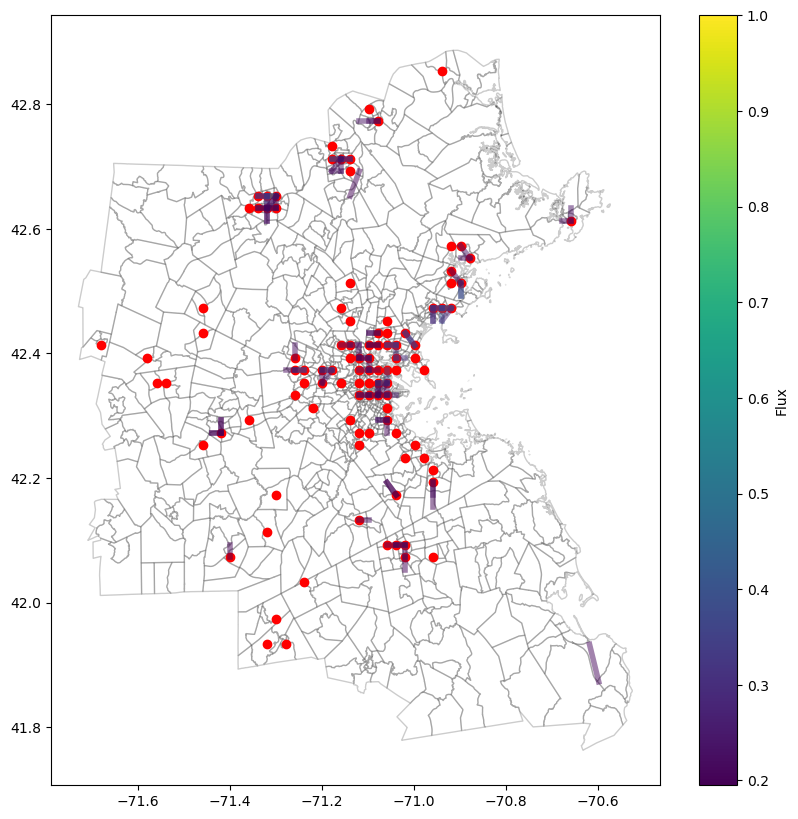

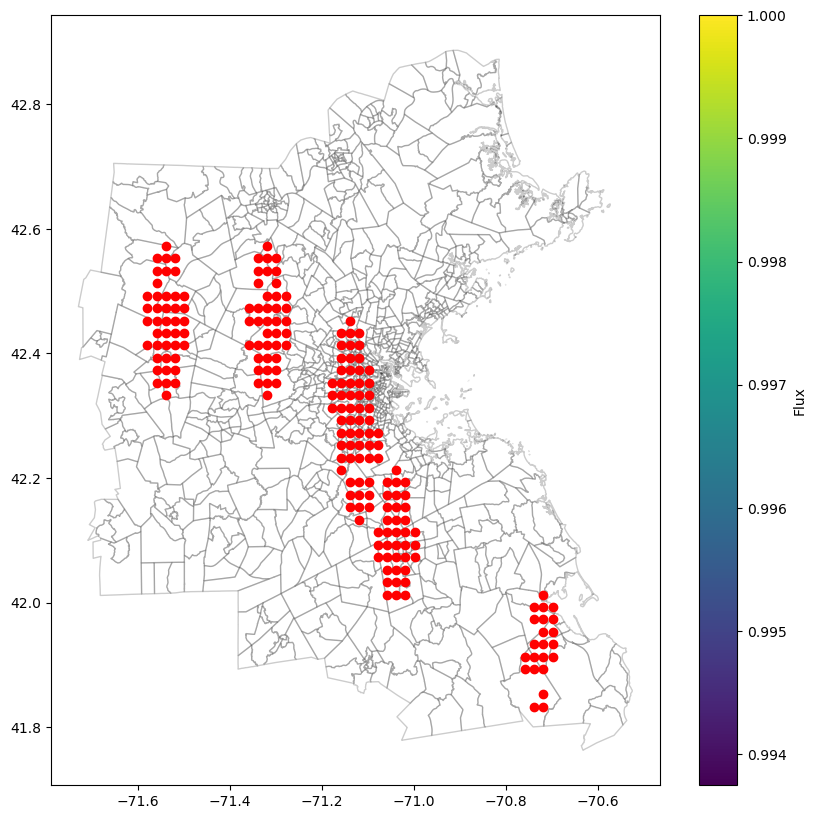

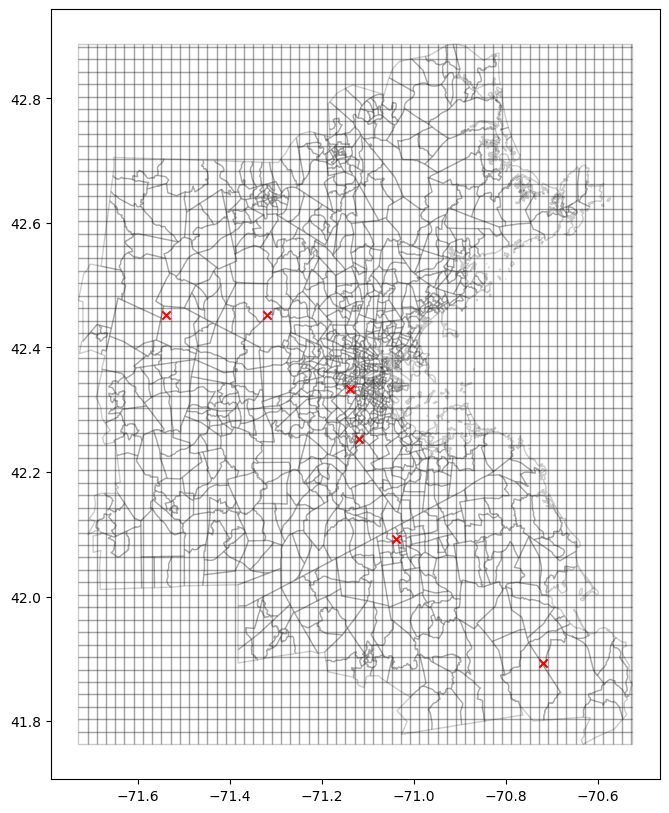

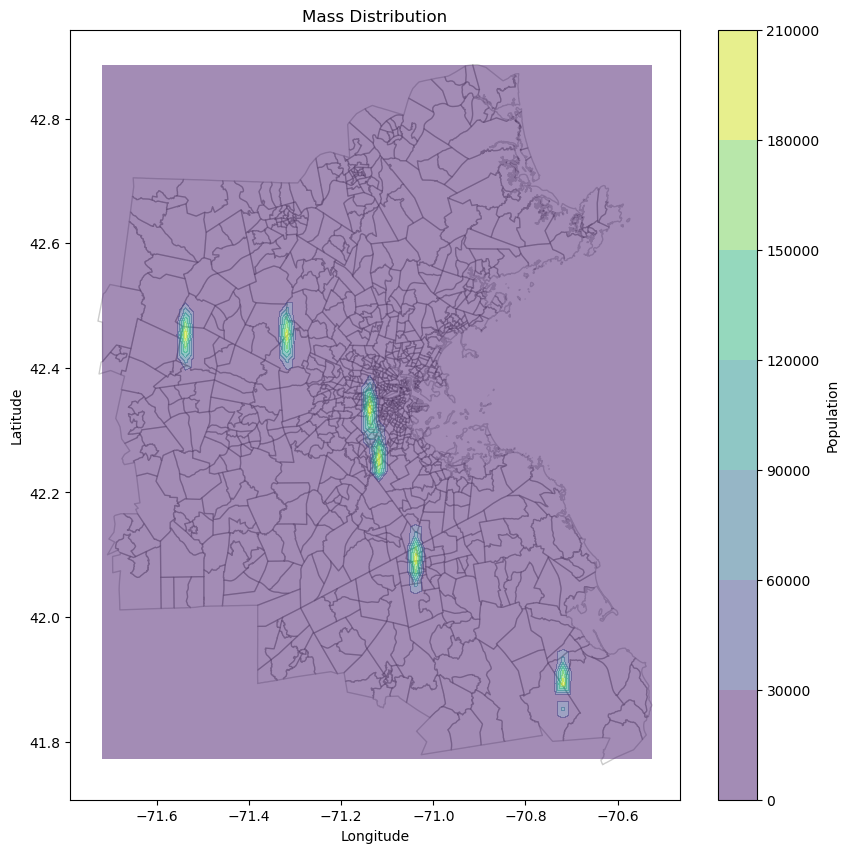

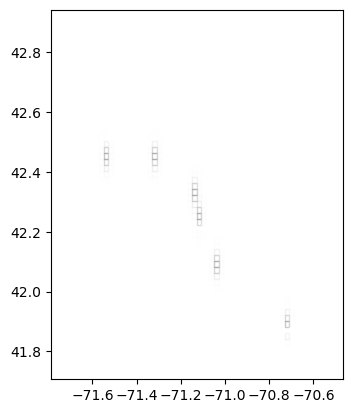

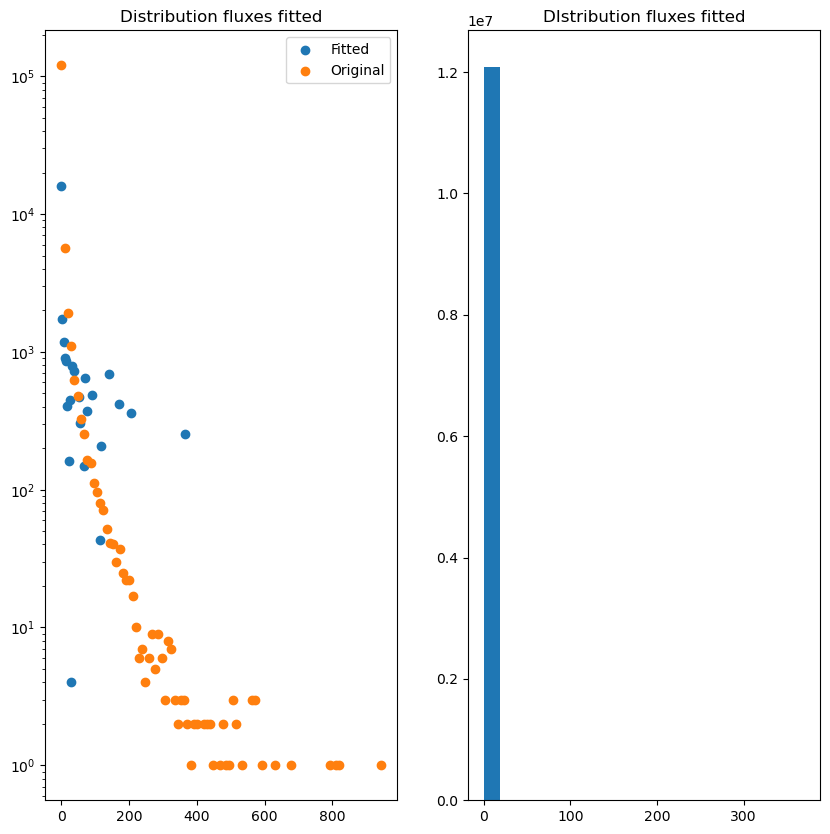

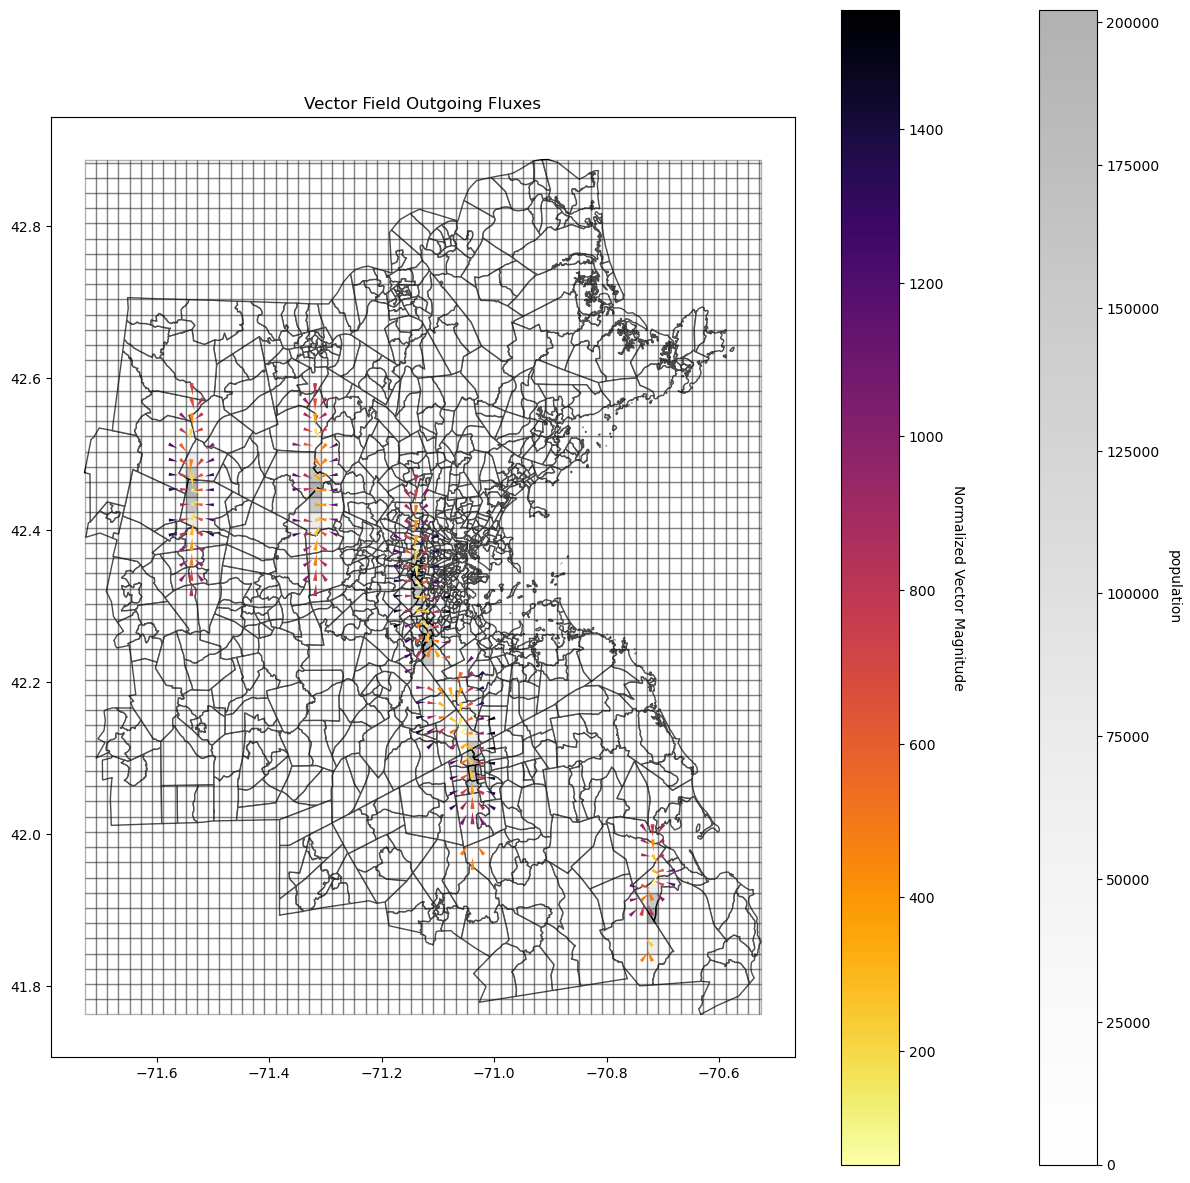

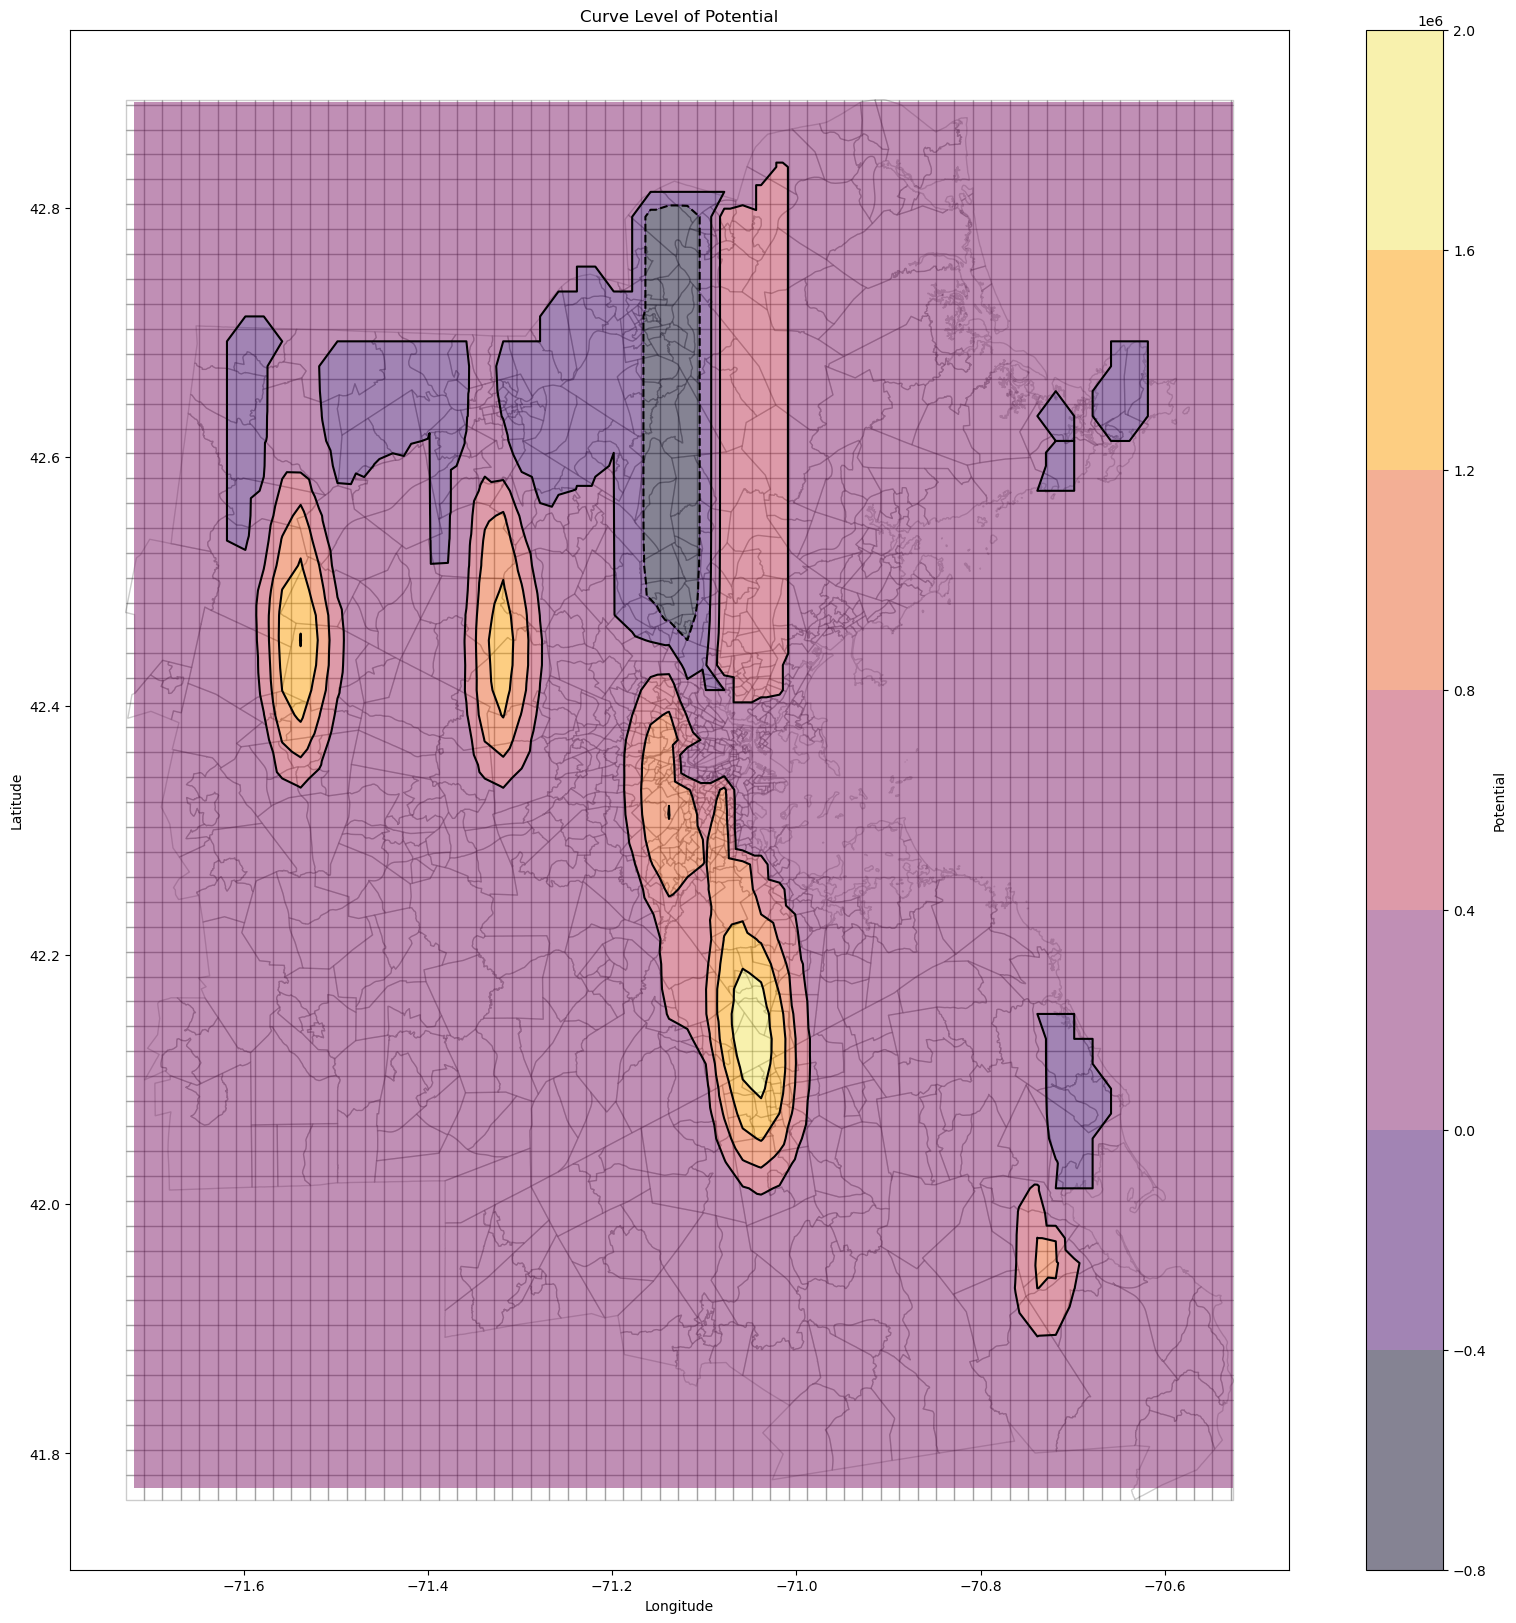

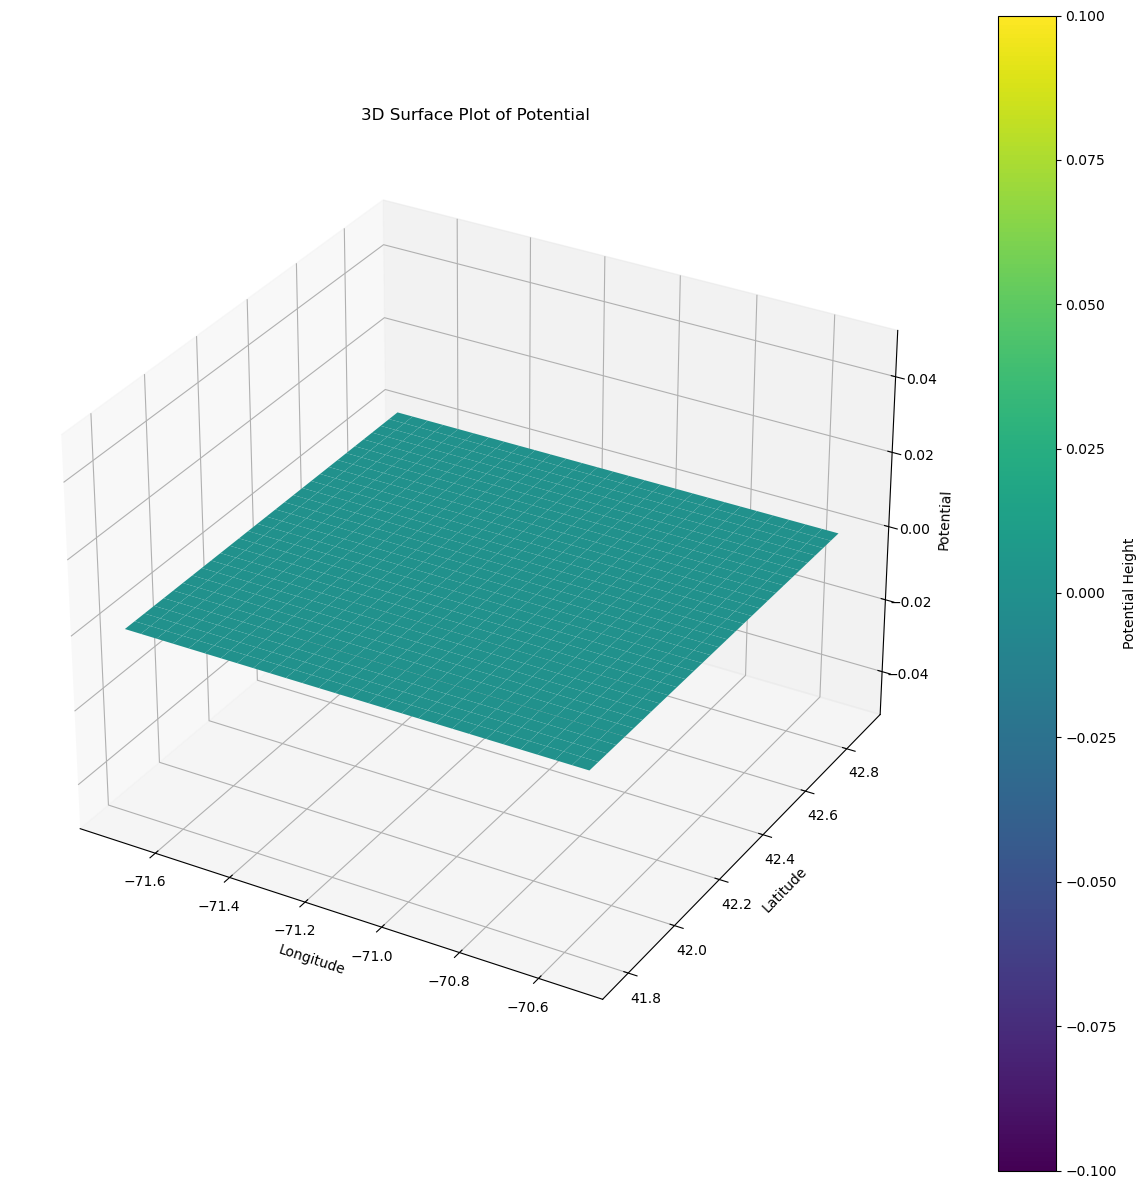

3345


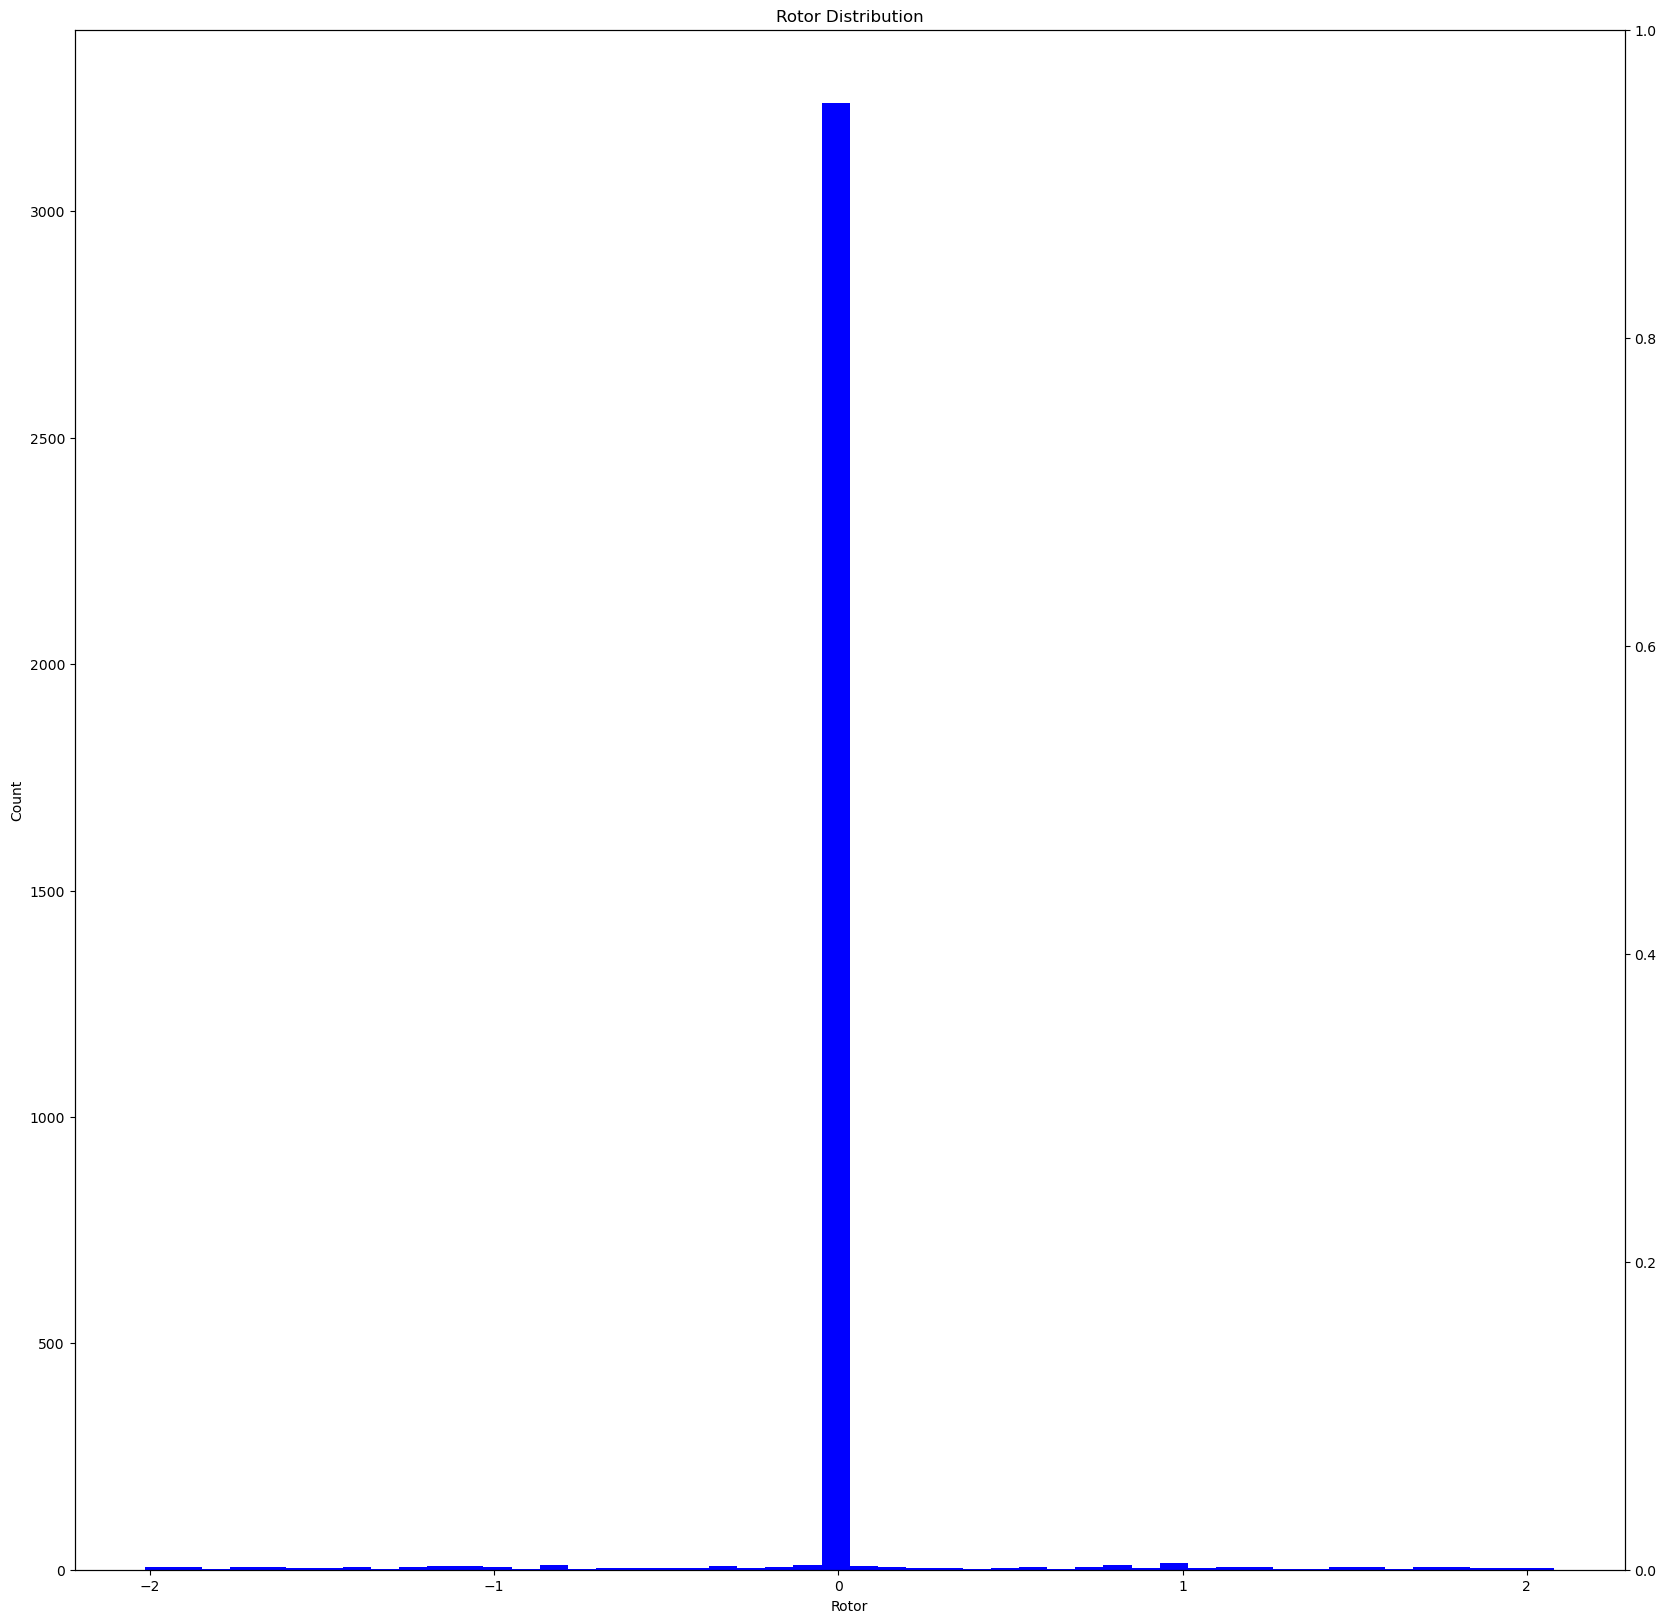

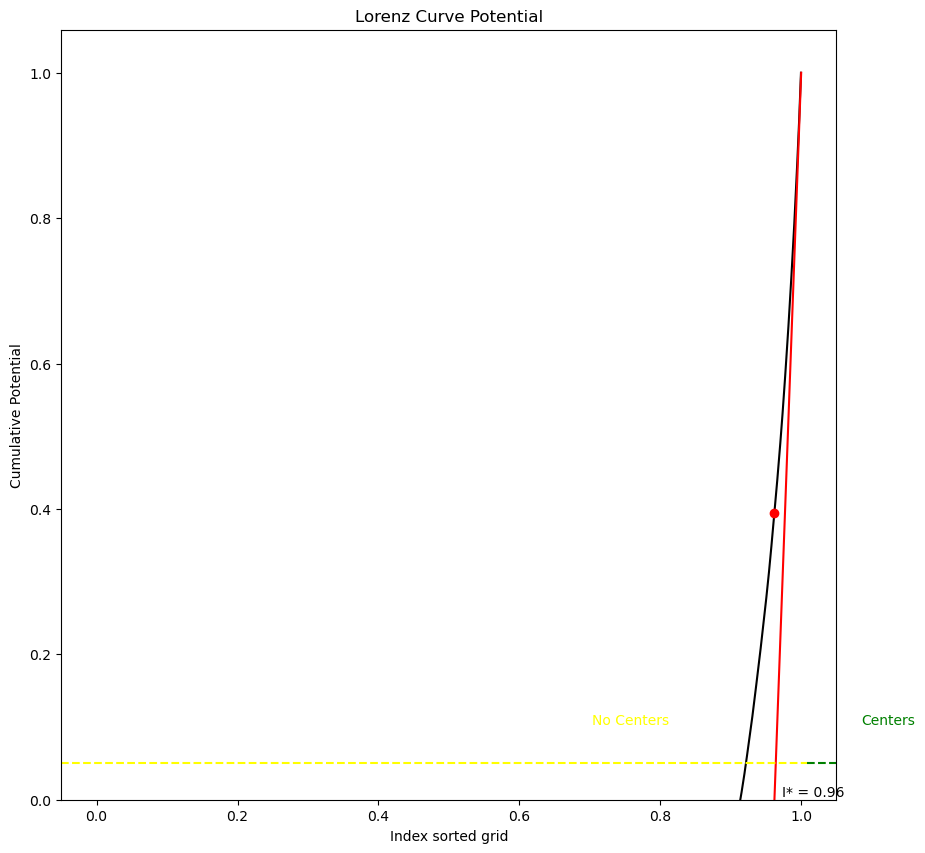

index Fstar:  3345
cumulative:  [-0.00303519 -0.00607038 -0.00910557 ...  0.98494487  0.99243663
  1.        ]
x:  [0.00000000e+00 2.87604257e-04 5.75208513e-04 ... 9.99137187e-01
 9.99424791e-01 9.99712396e-01]
x[idxFstar]:  0.9620362381363244
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
Modify Morphology 8
******************
Number of grids with people:  2157
Number of couples of grids with flux:  131478
Total Population:  4546481.94410453
Total Flux:  681885
Fraction of grids populated:  0.6203623813632442
Fraction of couples of grids with fluxes:  0.010875361645602571
******************
Plotting fluxes coming from raw data


In [2]:
with open('/home/aamad/Desktop/phd/berkeley/traffic_phase_transition/data/carto/BOS/grid/0.02/origindest2grid.json','r') as f:
    OD2grid = json.load(f)

with open('/home/aamad/Desktop/phd/berkeley/traffic_phase_transition/data/carto/BOS/grid/0.02/grid2origindest.json','r') as f:
    grid2OD = json.load(f)
with open('/home/aamad/Desktop/phd/berkeley/traffic_phase_transition/data/carto/BOS/osmid2idx.json') as f:
    osmid2index = json.load(f)

list_peaks = [2,3,4,5,6,8,10,100]
InfoConfigurationPolicentricity = {num_peaks: defaultdict() for num_peaks in list_peaks}
Covarinaces = [1,2,4,8,10,15,20,30,50,100,1000]
for cv in Covarinaces:
    for distribution in ['gaussian','exponential']:
        InfoCenters = {'center_settings': {"type":distribution},'covariance_settings':{"covariances":{"cvx":cv,"cvy":cv},"Isotropic": True,"Random": False}}
        #parameter_values = ((InfoConfigurationPolicentricity,grid,SFO_obj,Tij,df_distance,num_peaks) for num_peaks in list_peaks)
        for num_peaks in list_peaks:
            ModifyMorphologyCity(InfoConfigurationPolicentricity,grid,SFO_obj,Tij,df_distance,lattice,num_peaks,TRAFFIC_DIR,name,grid_size,InfoCenters,fraction_fluxes = 200,verbose = True)
#    OD_from_T_Modified(InfoConfigurationPolicentricity[pv[-1]]['Tij'],CityName2RminRmax,'BOS',osmid2index,grid2OD,1,'/home/aamad/Desktop/phd/traffic_phase_transition/data/carto/BOS/OD',start = 7,end = 8)
#with multiprocessing.Pool(processes=multiprocessing.cpu_count() - 4) as pool:
    # Map the function to the parameter values
#    pool.map(ModifyMorphologyCity, parameter_values)


(60, 56)

# CREATION OD FILES

In [ ]:
'''
{'logk': 0.0003055803472447064, 'alpha': 0.0002546775749831938, 'gamma': -0.07627729954795813, '1/d0': 4.8774299414384545}
Number centers considered:  2
[ 3.37484752 51.76501691]
bin index:  2
Length filtered grid:  32  rv:  3.3748475174250743
bin index:  23
Length filtered grid:  60  rv:  51.76501690675754
New population:  574776957.9199114
k:  1.0003056270416752  alpha:  0.0002546775749831938  beta:  -0.07627729954795813  d0:  4.8774299414384545
<k*p>:  165358.83
<p**alpha>:  1.0017573
<p**beta>:  0.6491281
<exp(-d/d0)>:  0.010571069

'''


with open('/home/aamad/Desktop/phd/berkeley/traffic_phase_transition/data/carto/BOS/potential/FitVespignani.json','r')as f:
    fitGLM = json.load(f)
print(fitGLM)
k = np.exp(fitGLM['logk'])
alpha =fitGLM['alpha']
beta = fitGLM['gamma']
d0 = fitGLM['1/d0']
list_peaks = [2,3,4,5,6,8,10]
InfoConfigurationPolicentricity = {num_peaks: defaultdict() for num_peaks in list_peaks}
total_population = np.sum(grid['population'])
total_flux = np.sum(Tij['number_people'])

population,centroidx,centroidy,index,filtered_grid = FilterPopulation(grid)
coords_center,_ = ExtractCenterByPopulation(grid)

#CenterMass = ComputeCM(grid,coords_center)

grid['is_populated'] = grid['population']>0
grid['coords'] = grid.apply(lambda x: ProjCoordsTangentSpace(x['centroidx'],x['centroidy'],coords_center[0],coords_center[1]),axis = 1)
grid['distance_from_center'] = grid.apply(lambda x: polar_coordinates(np.array([x['centroidx'],x['centroidy']]),np.array(x['coords']))[0],axis = 1)
PrintInfoFluxPop(grid,Tij)
for num_peaks in list_peaks:
    InfoConfigurationPolicentricity[num_peaks]['grid'] = grid.copy()
    InfoConfigurationPolicentricity[num_peaks]['Tij'] = Tij.copy()
for num_peaks in list_peaks:
    print('Number centers considered: ',num_peaks)
    index_centers = GenerateIndexCenters(grid,num_peaks)
    PlotPositionCenters(grid,SFO_obj,index_centers)
    covariances = SetCovariances(index_centers)
    new_population = ComputeNewPopulation(grid,index_centers,covariances,total_population)
    # Store Data About Population and Fluxes
    
    Factor = np.sum(grid['population'])/np.sum(new_population)
    new_population = new_population*Factor
    InfoConfigurationPolicentricity[num_peaks]['grid']['population'] = new_population
    InfoConfigurationPolicentricity[num_peaks]['grid'].plot(column = 'population')
    plt.show()
#    IPF = ipfn.ipfn(np.array([new_population]), np.array([[int(total_population)]]), np.array([[0]]),convergence_rate=0.01, max_iteration=1000, verbose=True)
#    new_population_ipfn = IPF.iteration()
#    InfoConfigurationPolicentricity[num_peaks]['grid']['new_population'] = new_population_ipfn[0][0]
    t0 = time.time() 
    Modified_Fluxes =  GravitationalModel(InfoConfigurationPolicentricity[num_peaks]['grid']['population'].to_numpy(dtype = np.float32),df_distance['distance'].to_numpy(dtype = np.float32),k,alpha,beta,d0)
    Multiplicator = total_flux/Modified_Fluxes.sum()
    Modified_Fluxes = Modified_Fluxes*Multiplicator
    t1 = time.time()
    print('Time to compute the model: ',t1 - t0)
    t0 = time.time()
#    IPF = ipfn.ipfn(np.array([Modified_Fluxes]), np.array([[total_flux]]), np.array([[0]]),convergence_rate=0.01, max_iteration=1000, verbose=True)
#    Modified_Fluxes_ipfn = IPF.iteration()
    InfoConfigurationPolicentricity[num_peaks]['Tij']['number_people'] = Modified_Fluxes    #Modified_Fluxes_ipfn[0][0]    
    print('Afeter Population Generation and Gravity:')
    PrintInfoFluxPop(InfoConfigurationPolicentricity[num_peaks]['grid'],InfoConfigurationPolicentricity[num_peaks]['Tij'])
    print("----------------------------------")
    n,bins = np.histogram(InfoConfigurationPolicentricity[num_peaks]['Tij']['number_people'].loc[InfoConfigurationPolicentricity[num_peaks]['Tij']['number_people']>0],bins = 100)
    n1,bins1 = np.histogram(Tij['number_people'].loc[Tij['number_people']>0],bins = 100)
    plt.scatter(bins[:-1],n)
    plt.scatter(bins1[:-1],n1)
    plt.yscale('log')
    plt.legend(['Fitted','Original'])
    plt.title('DIstribution fluxes fitted')
    plt.show()
    plt.hist(InfoConfigurationPolicentricity[num_peaks]['Tij']['number_people'],bins = 20)
    plt.title('DIstribution fluxes fitted')
    plt.show()
    t1 = time.time()
    print('Time to compute the ipfn: ',t1 - t0)    
    t0 = time.time()
    InfoConfigurationPolicentricity[num_peaks]['vector_field'] = GetVectorField(InfoConfigurationPolicentricity[num_peaks]['Tij'],df_distance)
    t1 = time.time()
    print('Time to compute the vector field: ',t1 - t0)
    lattice = GetPotentialLattice(lattice,InfoConfigurationPolicentricity[num_peaks]['vector_field'])
    lattice = SmoothPotential(lattice)
    InfoConfigurationPolicentricity[num_peaks]['potential'] = ConvertLattice2PotentialDataframe(lattice)
    InfoConfigurationPolicentricity[num_peaks]['potential'] = CompletePotentialDataFrame(VectorField,InfoConfigurationPolicentricity[num_peaks]['grid'],InfoConfigurationPolicentricity[num_peaks]['potential'])
    print('*********** COMPUTE UCI ************')
    SumPot = InfoConfigurationPolicentricity[num_peaks]['potential']['V_out'].sum()
    NumGridEdge = grid[grid['relation_to_line']=='edge'].shape[0]
    PI = LaunchComputationPI(df_distance,InfoConfigurationPolicentricity[num_peaks]['grid'],SumPot,NumGridEdge,InfoConfigurationPolicentricity[num_peaks]['potential'])
    result_indices,angle,cumulative,Fstar = LorenzCenters(InfoConfigurationPolicentricity[num_peaks]['potential']['V_out'].to_numpy())
    InfoConfigurationPolicentricity[num_peaks]['PI'] = PI
    LC = Fstar/len(cumulative)
    InfoConfigurationPolicentricity[num_peaks]['LC'] = LC
    UCI = PI*LC
    InfoConfigurationPolicentricity[num_peaks]['UCI'] = UCI
    print('Sum Potential: ',SumPot)
    print('Number of Edges boundary: ',NumGridEdge)
    print('LC: ',LC,'PI: ',PI,'UCI: ',UCI)
    print('************PLOTTING************')
    dir_grid = os.path.join(TRAFFIC_DIR,'data','carto',name,'OD')
    if not os.path.exists(dir_grid):
        os.mkdir(dir_grid)
    dir_grid = os.path.join(dir_grid,str(grid_size))
    if not os.path.exists(dir_grid):
        os.mkdir(dir_grid)
    dir_grid = os.path.join(dir_grid,str(num_peaks))
    if not os.path.exists(dir_grid):
        os.mkdir(dir_grid)
    dir_grid = os.path.join(dir_grid,'UCI_{}'.format(round(UCI,3)))
    if not os.path.exists(dir_grid):
        os.mkdir(dir_grid)
    PlotVFPotMass(InfoConfigurationPolicentricity[num_peaks]['grid'],SFO_obj,InfoConfigurationPolicentricity[num_peaks]['potential'],InfoConfigurationPolicentricity[num_peaks]['vector_field'],dir_grid,label_potential = 'population',label_fluxes = 'Ti')
    PotentialContour(InfoConfigurationPolicentricity[num_peaks]['grid'],InfoConfigurationPolicentricity[num_peaks]['potential'],SFO_obj,dir_grid)
    PotentialSurface(InfoConfigurationPolicentricity[num_peaks]['grid'],SFO_obj,InfoConfigurationPolicentricity[num_peaks]['potential'],dir_grid)
    PlotRotorDistribution(InfoConfigurationPolicentricity[num_peaks]['grid'],InfoConfigurationPolicentricity[num_peaks]['potential'],dir_grid)
    fig,ax = plt.subplots(1,1,figsize = (10,10))
    PlotLorenzCurve(ax,cumulative,Fstar,result_indices,shift = 0.1)

    

In [ ]:
PlotVFPotMass(InfoConfigurationPolicentricity[num_peaks]['grid'],SFO_obj,InfoConfigurationPolicentricity[num_peaks]['potential'],InfoConfigurationPolicentricity[num_peaks]['vector_field'],dir_grid,label_potential = 'population',label_fluxes = 'Ti')
PotentialContour(InfoConfigurationPolicentricity[num_peaks]['grid'],InfoConfigurationPolicentricity[num_peaks]['potential'],SFO_obj,dir_grid)
PotentialSurface(InfoConfigurationPolicentricity[num_peaks]['grid'],SFO_obj,InfoConfigurationPolicentricity[num_peaks]['potential'],dir_grid)
PlotRotorDistribution(InfoConfigurationPolicentricity[num_peaks]['grid'],InfoConfigurationPolicentricity[num_peaks]['potential'],dir_grid)
fig,ax = plt.subplots(1,1,figsize = (10,10))
PlotLorenzCurve(ax,cumulative,Fstar,result_indices,shift = 0.1)
